Risco de Doenças Cardíacas baseado em variáveis ambientais e sociodemográficas de dados públicos norte americanos

https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/data



https://github.com/kamilpytlak/data-science-projects/blob/main/heart-disease-prediction/2022/notebooks/data_processing.ipynb

https://www.kaggle.com/code/alphiree/cvds-risk-prediction-notebook-full

https://www.kaggle.com/code/aemreusta/heart-attack-prediction

https://www.kaggle.com/code/mhmedgaber/heart-diesese-detection-4-models-95/notebook

https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/code

Prediction 
APP and Article created referrences 

https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset

# LIBS


In [1]:
# libs
import os
import json
import zipfile
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from io import BytesIO
import plotly.express as px
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

# docling
# Mage AI

# Functions

In [8]:

# Função para buscar `var_info` de uma variável específica
def consultar_var_info(json_file_path, sas_variable_name):

    # Carregar o JSON
    with open(json_file_path, "r", encoding="utf-8") as f:
        variables_data = json.load(f)

    for variable in variables_data:
        if variable["SAS Variable Name"] == sas_variable_name:
            return variable["var_info"]
        
    return None  # Retorna None se a variável não for encontrada

# Função para buscar `var_info` de uma variável específica
def consultar_var_data_features(json_file_path, sas_variable_name, sas_variable_feature):

    # Carregar o JSON
    with open(json_file_path, "r", encoding="utf-8") as f:
        variables_data = json.load(f)

    for variable in variables_data:
        if variable["SAS Variable Name"] == sas_variable_name:
            return variable[sas_variable_feature]
        
    return None  # Retorna None se a variável não for encontrada

In [9]:

def contar_com_rotulo(
    df_brfss: pd.DataFrame,
    codebook_df: pd.DataFrame,
    coluna: str
) -> pd.Series:
    
    ''' 
    Substitui valores e nomes de variável com base no codebook e retorna o value_counts com rótulos legíveis.
    
    Parâmetros:
    - df_brfss: DataFrame com os dados brutos (valores numéricos)
    - df_codebook: DataFrame extraído do codebook
    - var_code: Nome da variável SAS no dataframe original (ex: 'CVDINFR4')
    
    Retorna:
    - Series com value_counts() indexado pelo valor legível
    
    '''
    # Verifica se a coluna existe no DataFrame
    if coluna not in df_brfss.columns:
        print(f"Coluna '{coluna}' não encontrada no DataFrame BRFSS.")
        return pd.Series(dtype=int)

    # Filtra o codebook para a variável
    codebook_var = codebook_df[codebook_df['SAS Variable Name'] == coluna]
    if codebook_var.empty:
        print(f"Variável '{coluna}' não encontrada no codebook.")
        return df_brfss[coluna].value_counts(dropna=False)

    # Remove valores nulos da coluna 'Value' do codebook
    codebook_var = codebook_var.dropna(subset=['Value'])

    # Cria dicionário de mapeamento: valor (como string) -> legenda
    mapa_valores = dict(zip(
        codebook_var['Value'].astype(str).str.strip(),
        codebook_var['Value Label']
    ))

    # Converte valores do BRFSS para strings compatíveis com o dicionário
    def limpar_valor(v):
        if pd.isna(v):
            return "BLANK"  # ou "Desconhecido"
        try:
            return str(int(v))  # ex: 1.0 -> '1'
        except:
            return str(v).strip()

    serie_convertida = df_brfss[coluna].apply(limpar_valor)
    serie_traduzida = serie_convertida.map(mapa_valores).fillna("Desconhecido")

    # Nome descritivo da variável
    nome_variavel = codebook_var['Label'].dropna().iloc[0] if not codebook_var['Label'].dropna().empty else coluna
    serie_traduzida.name = nome_variavel

    # Retorna a contagem com rótulos legíveis
    return serie_traduzida.value_counts(dropna=False)



In [10]:
def contar_com_rotulo_args(
    df_brfss: pd.DataFrame,
    codebook_df: pd.DataFrame,
    coluna: str,
    ordenar_por: str = 'frequencia'  # ou 'valor'
) -> pd.Series:
    
    if coluna not in df_brfss.columns:
        print(f"Coluna '{coluna}' não encontrada no DataFrame BRFSS.")
        return pd.Series(dtype=int)

    codebook_var = codebook_df[codebook_df['SAS Variable Name'] == coluna]
    if codebook_var.empty:
        print(f"Variável '{coluna}' não encontrada no codebook.")
        return df_brfss[coluna].value_counts(dropna=False)

    # Remove linhas com 'Value' ausente
    codebook_var = codebook_var.dropna(subset=['Value'])

    # Mapeamento valor -> rótulo
    mapa_valores = dict(zip(
        codebook_var['Value'].astype(str).str.strip(),
        codebook_var['Value Label']
    ))

    # Converte os valores do dataframe para string (com tratamento de NaNs)
    def limpar_valor(v):
        if pd.isna(v):
            return "BLANK"
        try:
            return str(int(v))
        except:
            return str(v).strip()

    serie_convertida = df_brfss[coluna].apply(limpar_valor)
    serie_traduzida = serie_convertida.map(mapa_valores).fillna("Desconhecido")
    nome_variavel = codebook_var['Label'].dropna().iloc[0] if not codebook_var['Label'].dropna().empty else coluna
    serie_traduzida.name = nome_variavel

    contagem = serie_traduzida.value_counts(dropna=False)

    # Reordenar, se necessário
    if ordenar_por == 'valor':
        ordem_valores = codebook_var['Value'].astype(str).str.strip().tolist()
        ordem_legendas = [mapa_valores.get(val, 'Desconhecido') for val in ordem_valores]
        contagem = contagem.reindex(ordem_legendas).dropna()

    return contagem


In [11]:
# mapeando o diretório do projeto e do arquivo notebook 
diretorio_atual_projeto = os.getcwd() # Diretório atual do arquivo
notebook_dir_project_predict = os.path.normpath(f"{diretorio_atual_projeto}{os.sep}..{os.sep}..{os.sep}") + os.sep # Diretório do projeto
print(diretorio_atual_projeto)
print(notebook_dir_project_predict)

/home/ed/lgcm/projects/riskPredictionDeseases/dev/notebooks
/home/ed/lgcm/projects/riskPredictionDeseases/


Behavioral Risk Factor Surveillance System

Links Importantes

Behavioral Risk Factor Surveillance System

Public health surveys of 400k people from 2011-2015

https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system

https://www.kaggle.com/code/shubhamshukla11/behavioral-risk-factor-surveillance-system/notebook


In [12]:
'''
def resumir_variavel_com_codebook(df_brfss, df_codebook, var_code):
    """
    Substitui valores e nomes de variável com base no codebook e retorna o value_counts com rótulos legíveis.
    
    Parâmetros:
    - df_brfss: DataFrame com os dados brutos (valores numéricos)
    - df_codebook: DataFrame extraído do codebook
    - var_code: Nome da variável SAS no dataframe original (ex: 'CVDINFR4')
    
    Retorna:
    - Series com value_counts() indexado pelo valor legível
    """
    # Verifica se a variável existe no DataFrame
    if var_code not in df_brfss.columns:
        print(f"Variável '{var_code}' não encontrada no DataFrame BRFSS.")
        return pd.Series(dtype=int)

    # Filtra o codebook para a variável
    subset = df_codebook[df_codebook['SAS Variable Name'] == var_code]
    if subset.empty:
        print(f"Variável '{var_code}' não encontrada no codebook.")
        return df_brfss[var_code].value_counts(dropna=False)

    # Remove valores nulos da coluna 'Value' do codebook
    subset = subset.dropna(subset=['Value'])

    # Cria dicionário de mapeamento: valor (como string) -> legenda
    mapa_valores = dict(zip(
        subset['Value'].astype(str).str.strip(),
        subset['Value Label']
    ))

    # Converte os valores da coluna no BRFSS em string no formato compatível
    def padronizar_valor(v):
        if pd.isna(v):
            return "BLANK"
        try:
            return str(int(v))  # ex: 1.0 → '1'
        except:
            return str(v).strip()

    serie_convertida = df_brfss[var_code].apply(padronizar_valor)
    serie_legenda = serie_convertida.map(mapa_valores).fillna("Desconhecido")

    # Nome descritivo da variável
    nome_legivel = subset['Label'].dropna().iloc[0] if not subset['Label'].dropna().empty else var_code
    serie_legenda.name = nome_legivel

    # Retorna a contagem com rótulos legíveis
    return serie_legenda.value_counts(dropna=False)


resumo = resumir_variavel_com_codebook(
    df_brfss_2023_csv,
    df_csv_path_expand_vars_translates,
    'CVDINFR4'
)
print(resumo)'''

'\ndef resumir_variavel_com_codebook(df_brfss, df_codebook, var_code):\n    """\n    Substitui valores e nomes de variável com base no codebook e retorna o value_counts com rótulos legíveis.\n    \n    Parâmetros:\n    - df_brfss: DataFrame com os dados brutos (valores numéricos)\n    - df_codebook: DataFrame extraído do codebook\n    - var_code: Nome da variável SAS no dataframe original (ex: \'CVDINFR4\')\n    \n    Retorna:\n    - Series com value_counts() indexado pelo valor legível\n    """\n    # Verifica se a variável existe no DataFrame\n    if var_code not in df_brfss.columns:\n        print(f"Variável \'{var_code}\' não encontrada no DataFrame BRFSS.")\n        return pd.Series(dtype=int)\n\n    # Filtra o codebook para a variável\n    subset = df_codebook[df_codebook[\'SAS Variable Name\'] == var_code]\n    if subset.empty:\n        print(f"Variável \'{var_code}\' não encontrada no codebook.")\n        return df_brfss[var_code].value_counts(dropna=False)\n\n    # Remove valo

In [13]:
# carregar os anos dosponíveis 


# BRFSS 2023

https://www.cdc.gov/brfss/annual_data/annual_2023.html

The 2023 BRFSS data continue to reflect the changes initially made in 2011 for weighting methodology (raking) and adding cell-phone-only respondents. The aggregate BRFSS combined landline and cell phone data set is built from the landline and cell phone data submitted for 2023 and includes data from 48 states, the District of Columbia, Guam, Puerto Rico, and the US Virgin Islands. During 2023, Kentucky and Pennsylvania were unable to collect enough data to meet the minimum requirements to be included in this public data set. The data set has been modified to comply with President Trump’s executive orders. There are some missing values which may appear to be inconsistencies in the data based on a respondents’ answers to questions that were removed.

Data

Ler dado bruto e converter para csv

## Código para obter o dado BRFSS 2023 diretamente do site do CDC

In [ ]:

# URL do arquivo ZIP que contém o .XPT
url = 'https://www.cdc.gov/brfss/annual_data/2023/files/LLCP2023XPT.zip'


# Baixar e extrair o arquivo .XPT do ZIP
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content)) as z:
    xpt_filename = [f for f in z.namelist() if f.endswith('.XPT ')][0]
    with z.open(xpt_filename) as xpt_file:
        df_2023_from_url = pd.read_sas(xpt_file, format='xport')

############ Salvar como CSV descomentar se necessário
input_dir = f'{notebook_dir_project_predict}data{os.sep}input{os.sep}'
os.makedirs(input_dir, exist_ok=True)
csv_path = os.path.join(input_dir, 'from_url_brfss_2023.csv')
df_2023_from_url.to_csv(csv_path, index=False)
print(f"Arquivo CSV salvo em: {csv_path}")


# df_2023_from_url

## Código para consumir o dado BRFSS 2023 localmente

In [ ]:
# Consumindo Localmente o arquivo XPT
# Caminho para o arquivo XPT (extraído do ZIP)
arquivo_xpt = f"{notebook_dir_project_predict}data{os.sep}input{os.sep}2023{os.sep}LLCP2023XPT{os.sep}LLCP2023.XPT "

# Carregar o arquivo no pandas
df_2023 = pd.read_sas(arquivo_xpt, format='xport')

# criar arquivo csv
df_2023.to_csv(f'{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023.csv', index=False)

df_2023

## Exibir informações gerais do dado

In [6]:
df_2023_csv = pd.read_csv(f'{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023.csv')

# salve num txt a saida do .info()
with open(f'{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_info.txt', 'w') as f:
    df_2023_csv.info(buf=f)


## Arquivo CODEBOOK das Variáveis

### Consumindo da WEB para CSV

In [ ]:
# URL do arquivo ZIP que contém o .XPT
url_codebook = 'https://www.cdc.gov/brfss/annual_data/2023/zip/codebook23_llcp-v2-508.zip'


# Baixar e extrair o arquivo .XPT do ZIP
response_url_codebook = requests.get(url_codebook)
with zipfile.ZipFile(BytesIO(response_url_codebook.content)) as z:
    html_filename = [f for f in z.namelist() if f.endswith('.HTML')][0]
    with z.open(html_filename, "r") as html_file:
        html_content = html_file.read()

soup = BeautifulSoup(html_content, 'html.parser')

# Lista para armazenar os dados extraídos
dados = []

# Encontrar todos os <td> que contêm as informações (ajuste o seletor se necessário)
tds = soup.find_all('td', class_='l m linecontent')

for td in tds:
    texto_bruto = td.get_text(separator="\n").strip()
    linhas = texto_bruto.split("\n")
    dado = {}

    for linha in linhas:
        if ":" in linha:
            chave, valor = linha.split(":", 1)
            chave = chave.strip().replace("\xa0", " ")  # Remove &nbsp;
            valor = valor.strip().replace("\xa0", " ")
            dado[chave] = valor

    # Adiciona o dicionário de cada variável na lista
    dados.append(dado)

# Transforma a lista de dicionários em DataFrame
df_vars_2023 = pd.DataFrame(dados)

# Se quiser salvar para Excel/CSV
# df_vars_2023.to_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis.csv", index=False)


### Consumindo Localmente para CSV

In [ ]:

# Suponha que você tenha carregado o HTML completo em uma variável chamada html_content
# Exemplo de leitura de um arquivo local
with open(f"{notebook_dir_project_predict}data{os.sep}input{os.sep}2023{os.sep}codebook23_llcp-v2-508{os.sep}USCODE23_LLCP_021924.HTML", "r", encoding="utf-8") as f:
    html_content = f.read()

soup = BeautifulSoup(html_content, 'html.parser')

# Lista para armazenar os dados extraídos
dados = []

# Encontrar todos os <td> que contêm as informações (ajuste o seletor se necessário)
tds = soup.find_all('td', class_='l m linecontent')

for td in tds:
    texto_bruto = td.get_text(separator="\n").strip()
    linhas = texto_bruto.split("\n")
    dado = {}

    for linha in linhas:
        if ":" in linha:
            chave, valor = linha.split(":", 1)
            chave = chave.strip().replace("\xa0", " ")  # Remove &nbsp;
            valor = valor.strip().replace("\xa0", " ")
            dado[chave] = valor

    # Adiciona o dicionário de cada variável na lista
    dados.append(dado)

# Transforma a lista de dicionários em DataFrame
df_vars_2023 = pd.DataFrame(dados)


# Se quiser salvar para Excel/CSV
# df_vars_2023.to_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis.csv", index=False)



In [ ]:
''' 
O Codebook tem apenas 344 variaveis, enquanto o dataframe tem 350 colunas.
Isso pode ocorrer por algumas razões:

1. **Variáveis não documentadas**: Algumas variáveis podem não estar documentadas no codebook, mas ainda existem no conjunto de dados.
2. **Variáveis temporárias ou de controle**: Algumas variáveis podem ser criadas para controle interno ou para processamento, mas não são relevantes para a análise final.
3. **Mudanças entre versões**: Se o conjunto de dados foi atualizado ou modificado, pode haver novas variáveis que não estão refletidas no codebook.
4. **Erros de documentação**: Pode haver erros ou omissões no codebook que não refletem com precisão todas as variáveis presentes no conjunto de dados.
5. **Variáveis de metadados**: Algumas colunas podem conter informações adicionais ou metadados que não são considerados variáveis principais.
6. **Variáveis de controle de qualidade**: Algumas variáveis podem ser usadas para verificar a qualidade dos dados ou para validação, mas não são relevantes para a análise principal.
7. **Variáveis de identificação**: Algumas colunas podem ser usadas para identificar registros ou participantes, mas não são consideradas variáveis de interesse para análise.
# 8. **Variáveis de agrupamento**: Algumas variáveis podem ser usadas para agrupar ou categorizar dados, mas não são relevantes para a análise principal.
# 9. **Variáveis de data/hora**: Algumas colunas podem conter informações de data ou hora que não são consideradas variáveis principais.
10. **Variáveis de resposta**: Algumas colunas podem conter respostas a perguntas específicas, mas não são consideradas variáveis principais para análise.
# 11. **Variáveis de controle de amostra**: Algumas colunas podem ser usadas para controlar a amostra ou o tamanho da amostra, mas não são relevantes para a análise principal.
# 12. **Variáveis de codificação**: Algumas colunas podem conter códigos ou identificadores que não são considerados variáveis principais para análise.
# 13. **Variáveis de resposta múltipla**: Algumas colunas podem conter respostas a perguntas de múltipla escolha, mas não são consideradas variáveis principais para análise.
# 14. **Variáveis de resposta aberta**: Algumas colunas podem conter respostas abertas que não são consideradas variáveis principais para análise.
# 15. **Variáveis de controle de qualidade**: Algumas colunas podem ser usadas para verificar a qualidade dos dados ou para validação, mas não são relevantes para a análise principal.
# 16. **Variáveis de controle de amostra**: Algumas colunas podem ser usadas para controlar a amostra ou o tamanho da amostra, mas não são relevantes para a análise principal.


'''

### Adicionar coluna com a tradução

In [ ]:

# Copiar o dataframe df_vars_2023
df_vars_2023_translated = pd.read_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis.csv")

# Função para traduzir texto
def traduzir_texto(texto, src_lang='en', target_lang='pt'):
    try:
        return GoogleTranslator(source=src_lang, target=target_lang).translate(texto)
    except Exception as e:
        print(f"Erro ao traduzir: {e}")
        return texto

# Adicionar coluna 'question_translate' com a tradução da coluna 'Question'
tqdm.pandas()  # Inicializa o tqdm para pandas
df_vars_2023_translated['question_translate'] = df_vars_2023_translated['Question'].progress_apply(lambda x: traduzir_texto(x))
df_vars_2023_translated['label_translate'] = df_vars_2023_translated['Label'].progress_apply(lambda x: traduzir_texto(x))
df_vars_2023_translated['section_name_translate'] = df_vars_2023_translated['Section Name'].progress_apply(lambda x: traduzir_texto(x))

# copiar o dataframe df_vars_2023 e adicionar question_translate com a tradução da string da coluna question
df_vars_2023_translated.to_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_translated.csv", index=False)


### CODEBOOK Completo em JSON

In [9]:
# Extração de todos dos dados do codebook html para um formato de dados json

from bs4 import BeautifulSoup
import pandas as pd
import json


# dado acima precisa ser complmentado com o resto dos detalhes das variáveis das colunas do dado de 2023
# mapeando as informaçoes do codebook se obtêm o seguinte estrutura de dados

# Ao mapear o arquivo do CODEBOOK temos as seguintes informações da variável
'''variable_data = {
    'Label': '',
    'Section Name': '',
    'Section Number': '',
    'Question Number': '',
    'Column': '',
    'Type of Variable': '',
    'SAS Variable Name': '',
    'Question Prologue': '',
    'Question': '',
    'var_info': {
            'Value': [],
            'Value Label': [],
            'Frequency': [],
            'Percentage': [],
            'Weighted Percentage': [],

    }
}
'''


# Caminho do arquivo HTML
html_path = f"{notebook_dir_project_predict}data{os.sep}input{os.sep}2023{os.sep}codebook23_llcp-v2-508{os.sep}USCODE23_LLCP_021924.HTML"

# Ler o HTML
with open(html_path, "r", encoding="utf-8") as f:
    html_content = f.read()

soup = BeautifulSoup(html_content, 'html.parser')

# Lista para armazenar os dados extraídos
variables_list = []

# Encontrar todas as tabelas no HTML
tables = soup.find_all("table")

for table in tables:
    # Captura a célula com os metadados (ajuste a classe se necessário)
    td = table.find('td', class_='l m linecontent')
    
    if td:
        # Captura os metadados
        texto_bruto = td.get_text(separator="\n").strip()
        linhas = texto_bruto.split("\n")
        
        variable_data = {
            'Label': '',
            'Section Name': '',
            'Section Number': '',
            'Question Number': '',
            'Column': '',
            'Type of Variable': '',
            'SAS Variable Name': '',
            'Question Prologue': '',
            'Question': '',
            'var_info': {
                'Value': [],
                'Value Label': [],
                'Frequency': [],
                'Percentage': [],
                'Weighted Percentage': []
            }
        }

        # Preenchendo os metadados
        for linha in linhas:
            if ":" in linha:
                chave, valor = linha.split(":", 1)
                chave = chave.strip().replace("\xa0", " ")  # Remove &nbsp;
                valor = valor.strip().replace("\xa0", " ")
                if chave in variable_data:
                    variable_data[chave] = valor

        # Nome da variável SAS
        var_name = variable_data['SAS Variable Name']
        if not var_name:
            continue  # Ignorar se não tem nome de variável SAS

        # Captura os cabeçalhos da tabela de valores
        headers = [th.text.strip() for th in table.find_all("th")]
        
        # Captura os valores da tabela
        for row in table.find_all("tr")[1:]:  # Pula cabeçalhos
            cols = [td.text.strip() for td in row.find_all("td")]
            if cols and len(cols) == len(headers):  # Evita erro de indexação
                for i, col in enumerate(cols):
                    header = headers[i]
                    if header in variable_data['var_info']:
                        variable_data['var_info'][header].append(col)

        # Adiciona à lista
        variables_list.append(variable_data)

# Converter para DataFrame (caso queira trabalhar com tabelas)
df_vars_2023 = pd.DataFrame(variables_list)

# Salvar CSV e JSON para consulta posterior
# df_vars_2023.to_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}brfss_2023_variaveis.csv", index=False)

json_vars_path_file = f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis.json"
with open(json_vars_path_file, "w", encoding="utf-8") as f:
    json.dump(variables_list, f, indent=4, ensure_ascii=False)

print("Extração concluída. Dados salvos em CSV e JSON.")





Extração concluída. Dados salvos em CSV e JSON.


### CODEBOOK Completo em CSV

In [45]:
# Chaves fixas que queremos manter
CHAVES_FIXAS = [
    'Label',
    'Section Name',
    'Section Number',
    'Question Number',
    'Column',
    'Type of Variable',
    'SAS Variable Name',
    'Question Prologue',
    'Question'
]

CHAVES_VAR_INFO = [
    'Value',
    'Value Label',
    'Frequency',
    'Percentage',
    'Weighted Percentage'
]

def expandir_variavel_em_tabela_filtrada(dado_var):
    """Expande uma variável, mantendo só as chaves desejadas."""
    var_info = dado_var.get("var_info", {})
    n = len(var_info.get("Value", []))  # Número de valores a expandir

    # Filtros só com chaves que queremos
    fixos_filtrados = {k: [dado_var.get(k, '')] * n for k in CHAVES_FIXAS}
    var_info_filtrado = {k: var_info.get(k, [''] * n) for k in CHAVES_VAR_INFO}

    # Combinar tudo
    fixos_filtrados.update(var_info_filtrado)
    return pd.DataFrame(fixos_filtrados)

def carregar_json_com_filtro(json_path):
    """Lê o JSON e transforma em uma única tabela filtrada."""
    with open(json_path, "r", encoding="utf-8") as f:
        dados = json.load(f)

    tabelas = [expandir_variavel_em_tabela_filtrada(var) for var in dados]
    return pd.concat(tabelas, ignore_index=True)


json_path = f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis.json"
df_resultado = carregar_json_com_filtro(json_path)

df_resultado.to_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_expandidas.csv", index=False)



### Adicionar colunas com a tradução

In [ ]:

# Copiar o dataframe df_vars_2023
df_vars_2023_expand_translated = pd.read_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_expandidas.csv")

# Função para traduzir texto
def traduzir_texto(texto, src_lang='en', target_lang='pt'):
    try:
        return GoogleTranslator(source=src_lang, target=target_lang).translate(texto)
    except Exception as e:
        print(f"Erro ao traduzir: {e}")
        return texto

# Adicionar coluna 'question_translate' com a tradução da coluna 'Question'
tqdm.pandas()  # Inicializa o tqdm para pandas
df_vars_2023_expand_translated['label_translate'] = df_vars_2023_expand_translated['Label'].progress_apply(lambda x: traduzir_texto(x))
df_vars_2023_expand_translated['section_name_translate'] = df_vars_2023_expand_translated['Section Name'].progress_apply(lambda x: traduzir_texto(x))
df_vars_2023_expand_translated['question_translate'] = df_vars_2023_expand_translated['Question'].progress_apply(lambda x: traduzir_texto(x))
df_vars_2023_expand_translated['value_label_translate'] = df_vars_2023_expand_translated['Value Label'].progress_apply(lambda x: traduzir_texto(x))

# copiar o dataframe df_vars_2023 e adicionar question_translate com a tradução da string da coluna question
df_vars_2023_expand_translated.to_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_expandidas_translated.csv", index=False)


In [11]:
df_vars_2023_expand_translated_read = pd.read_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_expandidas_translated.csv")
df_vars_2023_expand_translated_read

,Label,Section Name,Section Number,Question Number,Column,Type of Variable,SAS Variable Name,Question Prologue,Question,Value,Value Label,Frequency,Percentage,Weighted Percentage,label_translate,section_name_translate,question_translate,value_label_translate
0,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,1,Alabama,"4,362",1.01,1.58,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Alabama
1,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,2,Alaska,"5,525",1.28,0.22,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Alasca
2,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,4,Arizona,"12,036",2.78,2.31,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Arizona
3,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,5,Arkansas,"5,351",1.23,0.94,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Arkansas
4,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,6,California,"11,976",2.76,12.18,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Califórnia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891,Always Wear Seat Belts,Calculated Variables,NaN,2,2109,Num,_RFSEAT3,NaN,Always Wear Seat Belts Calculated Variable,2,Don't Always Wear Seat Belt,"50,738",11.71,10.99,Sempre use cintos de segurança,Variáveis ​​calculadas,Sempre use cintos de segurança variável calculada,Nem sempre use cinto de segurança
1892,Always Wear Seat Belts,Calculated Variables,NaN,2,2109,Num,_RFSEAT3,NaN,Always Wear Seat Belts Calculated Variable,9,Don't know/Not Sure Or Refused/Missing,"31,505",7.27,8.70,Sempre use cintos de segurança,Variáveis ​​calculadas,Sempre use cintos de segurança variável calculada,Não sei/não tenho certeza ou recusou/ausente
1893,Drinking and Driving,Calculated Variables,NaN,3,2110,Num,_DRNKDRV,NaN,Drinking and Driving (Reported having driven ...,1,Have driven after having too much to drink,"6,192",1.43,1.36,Bebendo e dirigindo,Variáveis ​​calculadas,Beber e dirigir (relatou ter dirigido pelo men...,Dirigiram depois de beber muito
1894,Drinking and Driving,Calculated Variables,NaN,3,2110,Num,_DRNKDRV,NaN,Drinking and Driving (Reported having driven ...,2,Have not driven after having too much to drink,"205,541",47.43,45.81,Bebendo e dirigindo,Variáveis ​​calculadas,Beber e dirigir (relatou ter dirigido pelo men...,Não dirigiram depois de beber muito


Retornar uma fração do Codebook no formato JSON ou CSV 

### fração do Codebook JSON

In [31]:
'''variable_data = {
    'Label': '',
    'Section Name': '',
    'Section Number': '',
    'Question Number': '',
    'Column': '',
    'Type of Variable': '',
    'SAS Variable Name': '',
    'Question Prologue': '',
    'Question': '',
    'var_info': {
            'Value': [],
            'Value Label': [],
            'Frequency': [],
            'Percentage': [],
            'Weighted Percentage': [],

    }
}
'''

age_var = 'CVDSTRK3'
feature_var = 'var_info'

# Caminho do JSON gerado
json_path = f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis.json"
 # Substitua pelo nome da variável desejada
var_info = consultar_var_data_features(json_file_path=json_path, 
                                       sas_variable_name=age_var,
                                       sas_variable_feature=feature_var)

if var_info:
    print(f"Informações para {age_var}:")
    print(json.dumps(var_info, indent=4, ensure_ascii=False))
else:
    print(f"Variável {age_var} não encontrada.")



Informações para CVDSTRK3:
{
    "Value": [
        "1",
        "2",
        "7",
        "9",
        "BLANK"
    ],
    "Value Label": [
        "Yes",
        "No",
        "Don't know/Not sure",
        "Refused",
        "Not asked or Missing"
    ],
    "Frequency": [
        "18,350",
        "413,499",
        "1,212",
        "258",
        "4"
    ],
    "Percentage": [
        "4.23",
        "95.43",
        "0.28",
        "0.06",
        "."
    ],
    "Weighted Percentage": [
        "3.37",
        "96.30",
        "0.26",
        "0.06",
        "."
    ]
}


### fração do Codebook Tabela

In [20]:


sas_variable_test = "_AGEG5YR"  # Substitua pelo nome da variável desejada
sas_variable_heart = "CVDSTRK3"  # Substitua pelo nome da variável desejada
# CVDINFR4 Heart Attack
# CVDCRHD4 Angina
# CVDSTRK3 Stroke


# Caminho do JSON gerado

json_path_file_to_csv = f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis.json"

var_info = consultar_var_info(json_file_path=json_path_file_to_csv, sas_variable_name=sas_variable_heart)

if var_info:
    # Criar DataFrame com os dados de var_info
    df_var_info = pd.DataFrame(var_info)
    
else:
    print(f"Variável {sas_variable_heart} não encontrada.")

df_var_info

,Value,Value Label,Frequency,Percentage,Weighted Percentage
0,1,Yes,"18,350",4.23,3.37
1,2,No,"413,499",95.43,96.30
2,7,Don't know/Not sure,"1,212",0.28,0.26
3,9,Refused,258,0.06,0.06
4,BLANK,Not asked or Missing,4,.,.


## Exploração dos dados

Listar as seções , ou tipos de informações

### Distribuição das geral das variáveis (colunas do dado) por seção

O Codebook traz informações sobre as variáveis , tais como 


CHAVES_FIXAS

    'Label',
    'Section Name', 
    'Section Number',
    'Question Number',
    'Column',
    'Type of Variable',
    'SAS Variable Name',
    'Question Prologue',
    'Question'


CHAVES_VAR_INFO

    'Value',
    'Value Label',
    'Frequency',
    'Percentage',
    'Weighted Percentage'


Tabela Codebook

In [35]:
df_vars_2023_data = pd.read_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_translated.csv")

In [51]:
df_vars_2023_data

,Label,Section Name,Section Number,Question Number,Column,Type of Variable,SAS Variable Name,Question Prologue,Question,Core Section Number,Module Number,question_translate,label_translate,section_name_translate
0,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,NaN,NaN,Código de FIPS do estado,Código de FIPS do estado,Identificação de registro
1,File Month,Record Identification,0.0,8,17-18,Num,FMONTH,NaN,File Month,NaN,NaN,Mês de arquivo,Mês de arquivo,Identificação de registro
2,Interview Date,Record Identification,0.0,9,19-26,Char,IDATE,NaN,Interview Date,NaN,NaN,Data da entrevista,Data da entrevista,Identificação de registro
3,Interview Month,Record Identification,0.0,10,19-20,Char,IMONTH,NaN,Interview Month,NaN,NaN,Mês da entrevista,Mês da entrevista,Identificação de registro
4,Interview Day,Record Identification,0.0,11,21-22,Char,IDAY,NaN,Interview Day,NaN,NaN,Dia da entrevista,Dia da entrevista,Identificação de registro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Pneumonia Vaccination Calculated Variable,Calculated Variables,NaN,2,2106,Num,_PNEUMO3,NaN,Adults aged 65+ who have ever had a pneumonia ...,NaN,13.0,Adultos com mais de 65 anos que já tiveram uma...,Vacinação de pneumonia calculada variável calc...,Variáveis ​​calculadas
340,Ever been tested for HIV calculated variable,Calculated Variables,NaN,1,2107,Num,_AIDTST4,NaN,Adults who have ever been tested for HIV,NaN,14.0,Adultos que já foram testados para o HIV,Já foi testado para variável calculada pelo HIV,Variáveis ​​calculadas
341,Always or Nearly Always Wear Seat Belts,Calculated Variables,NaN,1,2108,Num,_RFSEAT2,NaN,Always or Nearly Always Wear Seat Belts Calcul...,NaN,15.0,Sempre ou quase sempre use cintos de segurança...,Sempre ou quase sempre use cintos de segurança,Variáveis ​​calculadas
342,Always Wear Seat Belts,Calculated Variables,NaN,2,2109,Num,_RFSEAT3,NaN,Always Wear Seat Belts Calculated Variable,NaN,15.0,Sempre use cintos de segurança variável calculada,Sempre use cintos de segurança,Variáveis ​​calculadas


Lista de Categorias

In [44]:
list_df_vars_2023_data = list(df_vars_2023_data['Section Name'].unique())
# Salvar a lista em um arquivo de texto
with open(f'{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_list_section_name.txt', 'w') as f:
    for item in list_df_vars_2023_data:
        f.write(f"{item}\n")


In [48]:
# usaremos as categorias para filtrar as variáveis desejadas
# são 58 categorias , com um valor entre 70 ou 1 variável,um total de 350 variáveis
section_name_unique = [
 'Record Identification',
 'Land Line Introduction',
 'Cell Phone Introduction',
 'Respondent Sex',
 'Health Status',
 'Healthy Days',
 'Health Care Access',
 'Exercise (Physical Activity)',
 'Hypertension Awareness',
 'Cholesterol Awareness',
 'Chronic Health Conditions', # aqui nessa categoria teremos a variável target se tem ou não ataque cardíaco
 'Demographics',
 'Disability',
 'Falls',
 'Tobacco Use',
 'Alcohol Consumption',
 'Immunization',
 'HIV/AIDS',
 'Seatbelt Use and Drinking and Driving',
 'Long-term COVID Effects',
 'Pre-Diabetes',
 'Diabetes',
 'Arthritis',
 'Lung Cancer Screening',
 'Breast and Cervical Cancer Screening',
 'Prostate Cancer Screening',
 'Colorectal Cancer Screening',
 'Cancer Survivorship: Type of Cancer',
 'Cancer Survivorship: Course of Treatment',
 'Cancer Survivorship: Pain Management',
 'Indoor Tanning',
 'Excess Sun Exposure',
 'Cognitive Decline',
 'Caregiver',
 'Tobacco Cessation',
 'Other Tobacco Use',
 'Firearm Safety',
 'Heart Attack and Stroke', # as variáveis dessa categoria decem ser usadas para criar o novo dataframe , onde elas não são missing data (9 mil amostras)
 'Aspirin for CVD Prevention',
 'Sexual Orientation',
 'Marijuana Use',
 'Adverse Childhood Experiences',
 'Place of Flu Vaccination',
 'HPV Vaccination',
 'Tetanus Diphtheria (Tdap) (Adults)',
 'COVID Vaccination',
 'Social Determinants',
 'Reactions to Race',
 'Random Child Selection',
 'Childhood Asthma Prevalence',
 'Questionnaire Version',
 'Questionnaire Language',
 'Urban Rural',
 'Weighting Variables',
 'Child Demographic Variables',
 'Child Weighting Variables',
 'Calculated Variables',
 'Calculated Race Variables'
 ]

Contagens das categorias

In [49]:
# categorias das variáveis
# Exibir as categorias únicas da coluna 'Section Name'

Section_counts = df_vars_2023_data['section_name_translate'].value_counts()

with open(f'{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_count_section_name.txt', 'w') as f:
    Section_counts.to_string(f)

# Contar as ocorrências de cada seção
data_sect = Section_counts.reset_index()
data_sect.columns = ['section_name_translate', 'count']  # renomeando colunas



Gráfico das contagens

In [50]:

fig = px.bar(data_sect, x="section_name_translate", 
             y="count", 
             text_auto=True,
             title="Vars Count by Section Name",
             width = 1800,
             height = 600
             )

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
# salvar figura
fig.write_image(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_vars_count_by_section_name.png")
fig.show()


### Identificação de relevância Semântica para o estudo 

In [ ]:
section_info = {
    'Record Identification'                    : ['Identificação técnica do registro.',                          'Provavelmente irrelevante'],
    'Land Line Introduction'                   : ['Introdução para entrevista via telefone fixo.',               'Provavelmente irrelevante'],
    'Cell Phone Introduction'                  : ['Introdução para entrevista via celular.',                     'Provavelmente irrelevante'],
    'Respondent Sex'                           : ['Sexo do respondente.',                                        'Altamente relevante'], ###
    'Health Status'                            : ['Autoavaliação geral de saúde.',                               'Altamente relevante'], ###
    'Healthy Days'                             : ['Dias com saúde ruim nos últimos 30 dias.',                    'Altamente relevante'], ###
    'Health Care Access'                       : ['Acesso a serviços de saúde.',                                 'Moderadamente relevante'],
    'Exercise (Physical Activity)'             : ['Prática de atividade física.',                                'Altamente relevante'], ###
    'Hypertension Awareness'                   : ['Histórico de pressão alta.',                                  'Altamente relevante'], ###
    'Cholesterol Awareness'                    : ['Histórico de colesterol alto.',                               'Altamente relevante'], ###
    'Chronic Health Conditions'                : ['Outras doenças crônicas.',                                    'Altamente relevante'], ### # aqui teremos a variável target se tem ou não ataque cardíaco
    'Demographics'                             : ['Idade, raça, escolaridade, etc.',                             'Altamente relevante'], ###
    'Disability'                               : ['Limitações físicas ou mentais.',                              'Moderadamente relevante'],
    'Falls'                                    : ['Histórico de quedas.',                                        'Provavelmente irrelevante'],
    'Tobacco Use'                              : ['Uso atual de cigarro.',                                       'Altamente relevante'], ###
    'Alcohol Consumption'                      : ['Consumo de álcool.',                                          'Altamente relevante'], ###
    'Immunization'                             : ['Histórico de vacinação geral.',                               'Provavelmente irrelevante'],
    'HIV/AIDS'                                 : ['Histórico de HIV/AIDS.',                                      'Provavelmente irrelevante'],
    'Seatbelt Use and Drinking and Driving'    : ['Uso de cinto e direção sob efeito de álcool.',                'Provavelmente irrelevante'],
    'Long-term COVID Effects'                  : ['Sequelas da COVID-19.',                                       'Moderadamente relevante'],
    'Pre-Diabetes'                             : ['Diagnóstico de pré-diabetes.',                                'Altamente relevante'], ###
    'Diabetes'                                 : ['Diagnóstico de diabetes.',                                    'Altamente relevante'], ###
    'Arthritis'                                : ['Doença nas articulações.',                                    'Provavelmente irrelevante'],
    'Lung Cancer Screening'                    : ['Triagem de câncer de pulmão.',                                'Provavelmente irrelevante'],
    'Breast and Cervical Cancer Screening'     : ['Triagem de câncer de mama/colo do útero.',                    'Provavelmente irrelevante'],
    'Prostate Cancer Screening'                : ['Triagem de câncer de próstata.',                              'Provavelmente irrelevante'],
    'Colorectal Cancer Screening'              : ['Triagem de câncer colorretal.',                               'Provavelmente irrelevante'],
    'Cancer Survivorship: Type of Cancer'      : ['Histórico de tipo de câncer.',                                'Provavelmente irrelevante'],
    'Cancer Survivorship: Course of Treatment' : ['Tratamento contra câncer.',                                   'Provavelmente irrelevante'],
    'Cancer Survivorship: Pain Management'     : ['Uso de medicamentos para dor.',                               'Provavelmente irrelevante'],
    'Indoor Tanning'                           : ['Bronzeamento artificial.',                                    'Provavelmente irrelevante'],
    'Excess Sun Exposure'                      : ['Exposição solar excessiva.',                                  'Provavelmente irrelevante'],
    'Cognitive Decline'                        : ['Declínio cognitivo percebido.',                               'Moderadamente relevante'],
    'Caregiver'                                : ['Pessoa que cuida de outra.',                                  'Provavelmente irrelevante'],
    'Tobacco Cessation'                        : ['Tentativa de parar de fumar.',                                'Moderadamente relevante'],
    'Other Tobacco Use'                        : ['Uso de tabaco alternativo.',                                  'Moderadamente relevante'],
    'Firearm Safety'                           : ['Segurança com armas de fogo.',                                'Provavelmente irrelevante'],
    'Heart Attack and Stroke'                  : ['Histórico de infarto ou AVC.',                                'Altamente relevante'], ### # as variáveis dessa categoria decem ser usadas para criar o novo dataframe , onde elas não são missing data (9 mil amostras)
    'Aspirin for CVD Prevention'               : ['Uso de aspirina para prevenção.',                             'Moderadamente relevante'],
    'Sexual Orientation'                       : ['Orientação sexual.',                                          'Provavelmente irrelevante'],
    'Marijuana Use'                            : ['Uso de maconha.',                                             'Altamente irrelevante'],
    'Adverse Childhood Experiences'            : ['Experiências adversas na infância.',                          'Moderadamente relevante'],
    'Place of Flu Vaccination'                 : ['Local da vacinação contra gripe.',                            'Provavelmente irrelevante'],
    'HPV Vaccination'                          : ['Vacinação contra HPV.',                                       'Provavelmente irrelevante'],
    'Tetanus Diphtheria (Tdap) (Adults)'       : ['Vacina contra tétano e difteria.',                            'Provavelmente irrelevante'],
    'COVID Vaccination'                        : ['Vacinação contra COVID-19.',                                  'Moderadamente relevante'],
    'Social Determinants'                      : ['Condições sociais que influenciam a saúde.',                  'Altamente relevante'], ###
    'Reactions to Race'                        : ['Percepção de tratamento racial.',                             'Moderadamente relevante'],
    'Random Child Selection'                   : ['Seleção aleatória de criança.',                               'Provavelmente irrelevante'],
    'Childhood Asthma Prevalence'              : ['Prevalência de asma infantil.',                               'Provavelmente irrelevante'],
    'Questionnaire Version'                    : ['Versão do questionário.',                                     'Provavelmente irrelevante'],
    'Questionnaire Language'                   : ['Idioma da entrevista.',                                       'Provavelmente irrelevante'],
    'Urban Rural'                              : ['Zona urbana ou rural.',                                       'Moderadamente relevante'],
    'Weighting Variables'                      : ['Variáveis de ponderação.',                                    'Provavelmente irrelevante'],
    'Child Demographic Variables'              : ['Demografia infantil.',                                        'Provavelmente irrelevante'],
    'Child Weighting Variables'                : ['Ponderação infantil.',                                        'Provavelmente irrelevante'],
    'Calculated Variables'                     : ['Variáveis derivadas (ex: IMC).',                              'Moderadamente relevante'],
    'Calculated Race Variables'                : ['Variáveis agrupadas de raça.',                                'Moderadamente relevante'] # selecionar separadamente a variável desejada
}

# referenciar artigos para corroborar com a seleção das variáveis


### Categorias filtradas por relevância

In [27]:
# trazer as chaves do dicionário section_info com a classificação de Altamente relevante
section_info_highly_relevant = {k: v for k, v in section_info.items() if v[1] == 'Altamente relevante'}
section_info_highly_relevant
# lista das chaves com o idendificador Altamente relevANte
section_info_highly_relevant_keys = list(section_info_highly_relevant.keys())
section_info_highly_relevant_keys

['Respondent Sex',
 'Health Status',
 'Healthy Days',
 'Exercise (Physical Activity)',
 'Hypertension Awareness',
 'Cholesterol Awareness',
 'Chronic Health Conditions',
 'Demographics',
 'Tobacco Use',
 'Alcohol Consumption',
 'Pre-Diabetes',
 'Diabetes',
 'Heart Attack and Stroke',
 'Social Determinants']

Dataframe filtrado de variáveis pelas categorias de interesse

In [ ]:
# SUB DATAFRAME DE df_vars_2023_data ONDE O NOME DA VARIÁVEL É IGUAL A CATEGORIA DO DICIONÁRIO section_info_highly_relevant
# Criar um novo DataFrame filtrando as linhas onde 'Section Name' está na lista de chaves
df_vars_2023_highly_relevant = df_vars_2023_data[df_vars_2023_data['Section Name'].isin(section_info_highly_relevant_keys)]
# Salvar o novo DataFrame

# df_vars_2023_highly_relevant.to_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_highly_relevant.csv", index=False)


Section_counts_relevant = df_vars_2023_highly_relevant['section_name_translate'].value_counts()

with open(f'{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_count_section_name_relevants.txt', 'w') as f:
    Section_counts_relevant.to_string(f)



data_sect_relevant = Section_counts_relevant.reset_index()
data_sect_relevant.columns = ['Section Name', 'count']  # renomeando colunas

fig_2 = px.bar(data_sect_relevant, x="Section Name", 
             y="count", 
             text_auto=True,
             title="Vars Count by Section Name",
             width = 1800,
             height = 600
             )

fig_2.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
# salvar figura
fig_2.write_image(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_vars_count_by_section_name_relevants.png")
fig_2.show()


### Variáveis relevantes para as categorias

In [ ]:
section_names_interest_list = [
    'Heart Attack and Stroke',
    'Chronic Health Conditions',
    # 'Demographics',
    # 'Health Status',
    # 'Hypertension Awareness',
    # 'Cholesterol Awareness',
    # 'Tobacco Use',
    # 'Alcohol Consumption'
    
]

df_brfss_2023_variaveis_to_filter_sec_name = pd.read_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_translated.csv")

df_vars_2023_filtered_interest_vars = df_brfss_2023_variaveis_to_filter_sec_name[df_brfss_2023_variaveis_to_filter_sec_name['Section Name'].isin(section_names_interest_list)]
df_vars_2023_filtered_interest_vars = df_vars_2023_filtered_interest_vars[['label_translate', 'section_name_translate', 'SAS Variable Name']]
df_vars_2023_filtered_interest_vars

### Variǘeis e seus valores no dado

In [ ]:
# trazer as variáveis e os tipos de dados da secction 'Heart Attack and Stroke' do codebook - dado expandido do codebook
df_jsov_vars_expanded = pd.read_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_expandidas.csv")

df_jsov_vars_expanded_sub = df_jsov_vars_expanded[df_jsov_vars_expanded['Section Name'].isin(section_names_interest_list)]
df_jsov_vars_expanded_sub = df_jsov_vars_expanded_sub[['Label', 'Section Name', 'SAS Variable Name', 'Value', 'Value Label', 'Frequency', 'Percentage', 'Weighted Percentage']]
df_jsov_vars_expanded_sub

In [ ]:
sas_vars_list = df_jsov_vars_expanded_sub['SAS Variable Name'].unique()
sas_vars_list

In [ ]:
''' 
Um vez que o foco do projeto é prever doenças cardiovasculares,
# as variáveis que podem ser usadas como alvo são:
 
Variável - Label
CVDINFR4 - Ever Diagnosed with Heart Attack
CVDCRHD4 - Ever Diagnosed with Angina or Coronary Heart Disease


# As variáveis que podem ser usadas como preditores são:


'''
# da categoria 'Chronic Health Conditions'
# temos duas variáveis que podemos usar como alvo
# CVDINFR4 Heart Attack
# CVDCRHD4 Angina


# da categoria 'Chronic Health Conditions'
# temos duas variáveis que podemos usar como alvo
# CVDINFR4 Heart Attack
# CVDCRHD4 Angina

## Explorar dado completo do BRFSS 2023

In [20]:
# dado completo do brfss_2023
df_brfss_2023_csv = pd.read_csv(f'{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023.csv')
df_brfss_2023_csv

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
0,1.0,1.0,b'03012023',b'03',b'01',b'2023',1100.0,b'2023000001',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0,1.0,1.0,9.0
1,1.0,1.0,b'01062023',b'01',b'06',b'2023',1100.0,b'2023000002',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,1.0,1.0,9.0
2,1.0,1.0,b'03082023',b'03',b'08',b'2023',1100.0,b'2023000003',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,1.0,1.0,9.0
3,1.0,1.0,b'03062023',b'03',b'06',b'2023',1100.0,b'2023000004',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,1.0,1.0,1.0,9.0
4,1.0,1.0,b'01062023',b'01',b'06',b'2023',1100.0,b'2023000005',2.023000e+09,1.0,...,7.000000e+00,1.0,4.700000e+01,1.0,2.0,1.0,2.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433318,78.0,12.0,b'12112023',b'12',b'11',b'2023',1100.0,b'2023002064',2.023002e+09,NaN,...,7.100000e+01,2.0,1.500000e+03,2.0,2.0,2.0,1.0,1.0,2.0,2.0
433319,78.0,12.0,b'01032024',b'01',b'03',b'2024',1100.0,b'2023002065',2.023002e+09,NaN,...,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,1.0,1.0,1.0,9.0
433320,78.0,12.0,b'12132023',b'12',b'13',b'2023',1100.0,b'2023002066',2.023002e+09,NaN,...,3.000000e+00,1.0,4.700000e+01,1.0,NaN,NaN,1.0,1.0,1.0,2.0
433321,78.0,12.0,b'12082023',b'12',b'08',b'2023',1100.0,b'2023002067',2.023002e+09,NaN,...,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0,1.0,1.0,9.0


In [9]:
# explorar as variáveis de interesse
print("registros , colunas = ", df_brfss_2023_csv.shape)
print("\n Nomes das colunas \n", df_brfss_2023_csv.columns) ## to see all the columns present in the df_brfss_2023_csv
print("\n Tipos de dados  \n\n ", df_brfss_2023_csv.dtypes)
print("\n\n Tipo e Contagem e nulos")
print( df_brfss_2023_csv.info())
## to see null value
nulos = df_brfss_2023_csv.isna().sum()
print("\n Dados nulos \n", nulos)
ebool = df_brfss_2023_csv.isna().any()
print("\n Dados booleanos \n", ebool)
print("\n\n tabela parcial\n")
print("\n\n informacoes complementares \n\n", df_brfss_2023_csv.describe())
print("\n\n Planilha \n\n" , df_brfss_2023_csv.head())

registros , colunas =  (433323, 350)

 Nomes das colunas 
 Index(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'CTELENM1',
       ...
       'DROCDY4_', '_RFBING6', '_DRNKWK2', '_RFDRHV8', '_FLSHOT7', '_PNEUMO3',
       '_AIDTST4', '_RFSEAT2', '_RFSEAT3', '_DRNKDRV'],
      dtype='object', length=350)

 Tipos de dados  

  _STATE      float64
FMONTH      float64
IDATE        object
IMONTH       object
IDAY         object
             ...   
_PNEUMO3    float64
_AIDTST4    float64
_RFSEAT2    float64
_RFSEAT3    float64
_DRNKDRV    float64
Length: 350, dtype: object


 Tipo e Contagem e nulos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Columns: 350 entries, _STATE to _DRNKDRV
dtypes: float64(345), object(5)
memory usage: 1.1+ GB
None

 Dados nulos 
 _STATE           0
FMONTH           0
IDATE            0
IMONTH           0
IDAY             0
             ...  
_PNEUMO3    262500
_AIDTST4     29613
_RFSEAT2

In [ ]:
# filtrar dataframe acima , onde as variáveis da categoria (Section Name) 'Heart Attack and Stroke' não são missing data
''' 
Variável - Label
CVDINFR4 - Ever Diagnosed with Heart Attack
CVDCRHD4 - Ever Diagnosed with Angina or Coronary Heart Disease
'''

In [15]:
csv_path_expand_vars_translates = f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis_expandidas_translated.csv"
df_csv_path_expand_vars_translates = pd.read_csv(csv_path_expand_vars_translates)
df_csv_path_expand_vars_translates

,Label,Section Name,Section Number,Question Number,Column,Type of Variable,SAS Variable Name,Question Prologue,Question,Value,Value Label,Frequency,Percentage,Weighted Percentage,label_translate,section_name_translate,question_translate,value_label_translate
0,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,1,Alabama,"4,362",1.01,1.58,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Alabama
1,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,2,Alaska,"5,525",1.28,0.22,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Alasca
2,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,4,Arizona,"12,036",2.78,2.31,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Arizona
3,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,5,Arkansas,"5,351",1.23,0.94,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Arkansas
4,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,6,California,"11,976",2.76,12.18,Código de FIPS do estado,Identificação de registro,Código de FIPS do estado,Califórnia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891,Always Wear Seat Belts,Calculated Variables,NaN,2,2109,Num,_RFSEAT3,NaN,Always Wear Seat Belts Calculated Variable,2,Don't Always Wear Seat Belt,"50,738",11.71,10.99,Sempre use cintos de segurança,Variáveis ​​calculadas,Sempre use cintos de segurança variável calculada,Nem sempre use cinto de segurança
1892,Always Wear Seat Belts,Calculated Variables,NaN,2,2109,Num,_RFSEAT3,NaN,Always Wear Seat Belts Calculated Variable,9,Don't know/Not Sure Or Refused/Missing,"31,505",7.27,8.70,Sempre use cintos de segurança,Variáveis ​​calculadas,Sempre use cintos de segurança variável calculada,Não sei/não tenho certeza ou recusou/ausente
1893,Drinking and Driving,Calculated Variables,NaN,3,2110,Num,_DRNKDRV,NaN,Drinking and Driving (Reported having driven ...,1,Have driven after having too much to drink,"6,192",1.43,1.36,Bebendo e dirigindo,Variáveis ​​calculadas,Beber e dirigir (relatou ter dirigido pelo men...,Dirigiram depois de beber muito
1894,Drinking and Driving,Calculated Variables,NaN,3,2110,Num,_DRNKDRV,NaN,Drinking and Driving (Reported having driven ...,2,Have not driven after having too much to drink,"205,541",47.43,45.81,Bebendo e dirigindo,Variáveis ​​calculadas,Beber e dirigir (relatou ter dirigido pelo men...,Não dirigiram depois de beber muito


### Distribuição das idades

In [ ]:
# _AGE80 - idades
# _AGEG5YR - faixas etárias

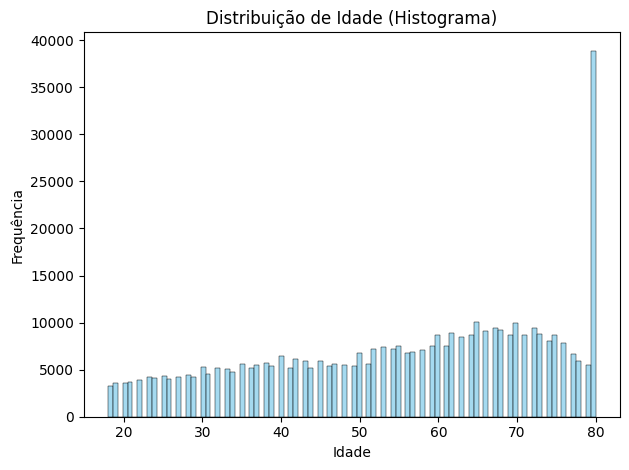

In [44]:
''''''
cont_age = df_brfss_2023_csv['_AGE80'].value_counts().sort_index(ascending=False)

sns.histplot(df_brfss_2023_csv['_AGE80'], bins=100, kde=False, color='skyblue')  # bins = 63 para 18 a 80
plt.title('Distribuição de Idade (Histograma)')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

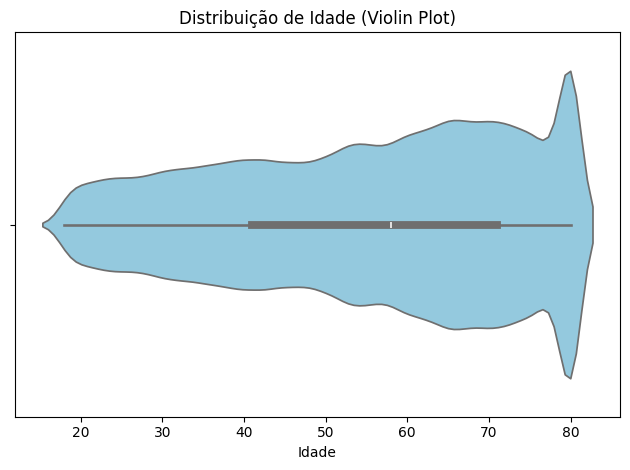

In [31]:
sns.violinplot(x=df_brfss_2023_csv['_AGE80'], color='skyblue')
plt.title('Distribuição de Idade (Violin Plot)')
plt.xlabel('Idade')
plt.tight_layout()
plt.show()

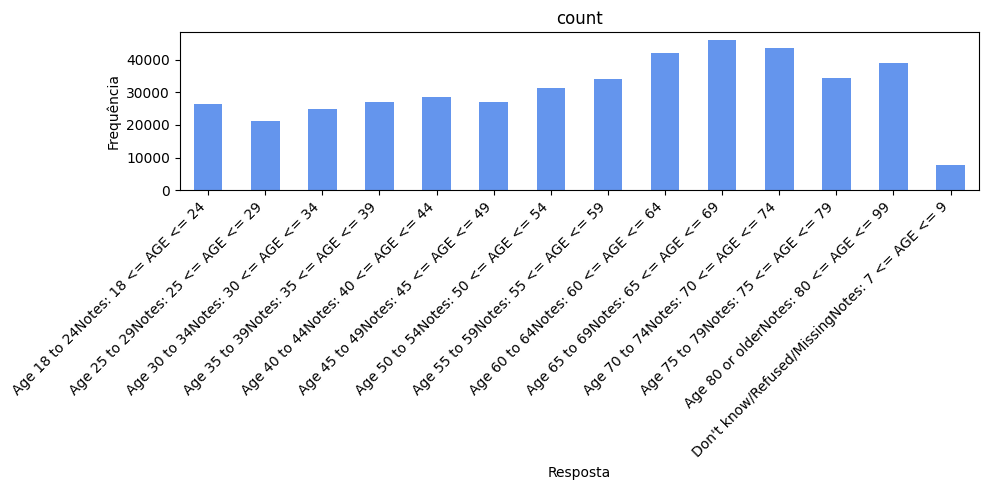

In [41]:
# Plota o gráfico de barras
cont = contar_com_rotulo_args(df_brfss_2023_csv, 
                              df_csv_path_expand_vars_translates, '_AGEG5YR',  
                              ordenar_por = 'valor' 
                              )
cont.plot(
    kind='bar',
    title=cont.name,  # Usa o nome legível da variável como título
    figsize=(10, 5),
    color='cornflowerblue'
)

plt.ylabel('Frequência')
plt.xlabel('Resposta')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

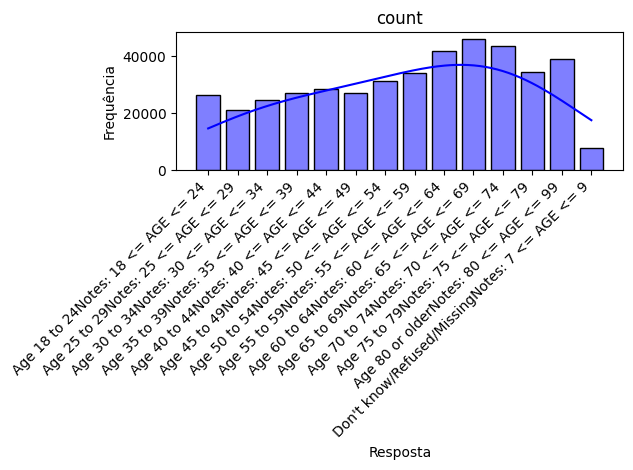

In [37]:


# Transforma em DataFrame para usar com Seaborn
df_legenda = cont.reset_index()
df_legenda.columns = ['Resposta', 'Frequência']

# Plot com Seaborn usando rótulos legíveis
sns.histplot(
    data=df_legenda,
    x='Resposta',
    weights='Frequência',
    discrete=True,
    shrink=0.8,
    color='blue',
    kde=True,
)

plt.title(cont.name)
plt.ylabel('Frequência')
plt.xlabel('Resposta')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### CVDINFR4 - Ever Diagnosed with Heart Attack
Variável - Label

In [32]:
sas_heart = 'CVDINFR4'
df_heart_attack = df_csv_path_expand_vars_translates[df_csv_path_expand_vars_translates['SAS Variable Name'] == sas_heart]
df_heart_attack = df_heart_attack[['SAS Variable Name', 'Label', 'label_translate', 'section_name_translate', 'Value', 'Value Label', 'Frequency', 'Percentage', 'Weighted Percentage', 'value_label_translate']]
df_heart_attack

,SAS Variable Name,Label,label_translate,section_name_translate,Value,Value Label,Frequency,Percentage,Weighted Percentage,value_label_translate
326,CVDINFR4,Ever Diagnosed with Heart Attack,Já diagnosticado com ataque cardíaco,Condições de saúde crônicas,1,Yes,"23,451",5.41,4.16,Sim
327,CVDINFR4,Ever Diagnosed with Heart Attack,Já diagnosticado com ataque cardíaco,Condições de saúde crônicas,2,No,"407,304",94.00,95.17,Não
328,CVDINFR4,Ever Diagnosed with Heart Attack,Já diagnosticado com ataque cardíaco,Condições de saúde crônicas,7,Don't know/Not sure,"2,314",0.53,0.61,Não sei/não tenho certeza
329,CVDINFR4,Ever Diagnosed with Heart Attack,Já diagnosticado com ataque cardíaco,Condições de saúde crônicas,9,Refused,251,0.06,0.05,Recusou
330,CVDINFR4,Ever Diagnosed with Heart Attack,Já diagnosticado com ataque cardíaco,Condições de saúde crônicas,BLANK,Not asked or Missing,3,.,.,Não perguntado ou desaparecido


In [43]:
contagem = contar_com_rotulo(df_brfss_2023_csv, df_csv_path_expand_vars_translates, 'CVDINFR4')
print(contagem)

Ever Diagnosed with Heart Attack
No                      407304
Yes                      23451
Don't know/Not sure       2314
Refused                    251
Not asked or Missing         3
Name: count, dtype: int64


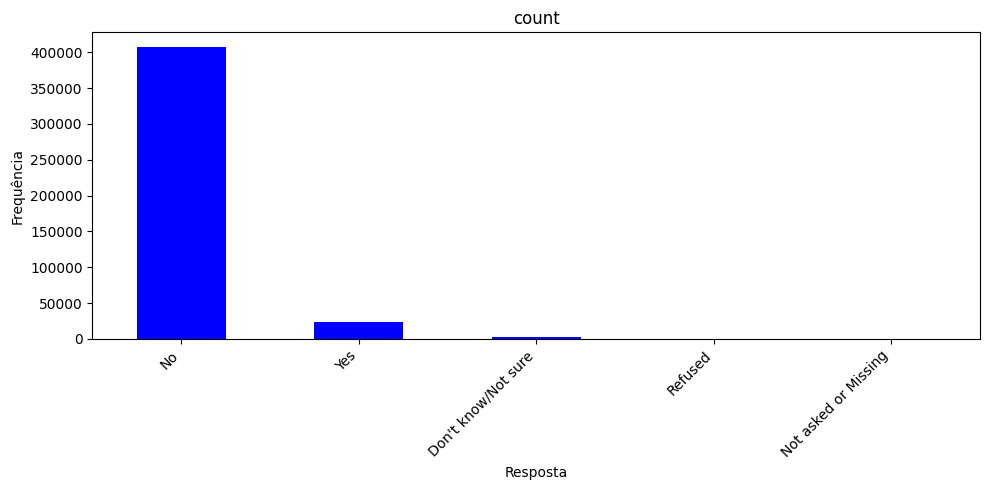

In [25]:

# Gerar a série traduzida com rótulos
contagem = contar_com_rotulo_args(df_brfss_2023_csv, df_csv_path_expand_vars_translates, 'CVDINFR4', ordenar_por='frequência')

# Criar o gráfico de barras com rótulos legíveis
contagem.plot(kind='bar', title=contagem.name, figsize=(10, 5), color='blue')
plt.ylabel('Frequência')
plt.xlabel('Resposta')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


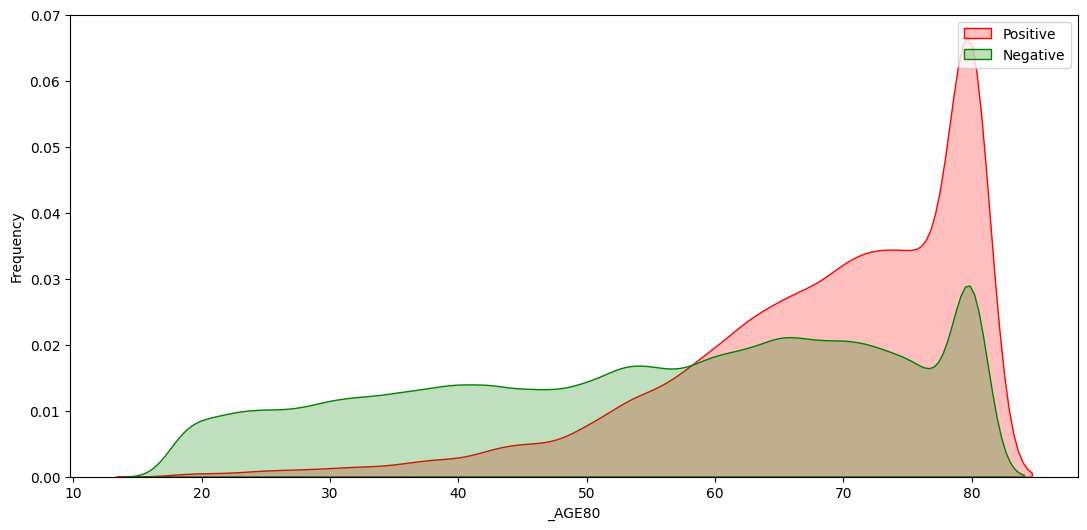

In [23]:
plt.figure(figsize=(13,6))
g = sns.kdeplot(df_brfss_2023_csv["_AGE80"][df_brfss_2023_csv["CVDINFR4"] == 1.0], color="Red", fill = True)
g = sns.kdeplot(df_brfss_2023_csv["_AGE80"][df_brfss_2023_csv["CVDINFR4"] == 2.0], ax =g, color="Green", fill= True)
g.set_xlabel("_AGE80")
g.set_ylabel("Frequency")
g.legend(["Positive","Negative"])

Variável - Label

### CVDCRHD4 - Ever Diagnosed with Angina or Coronary Heart Disease

In [18]:
sas_heart_coronary = 'CVDCRHD4'
df_heart_coronary = df_csv_path_expand_vars_translates[df_csv_path_expand_vars_translates['SAS Variable Name'] == sas_heart_coronary]
df_heart_coronary = df_heart_coronary[['SAS Variable Name', 'Label', 'label_translate', 'section_name_translate', 'Value', 'Value Label', 'Frequency', 'Percentage', 'Weighted Percentage', 'value_label_translate']]
df_heart_coronary

,SAS Variable Name,Label,label_translate,section_name_translate,Value,Value Label,Frequency,Percentage,Weighted Percentage,value_label_translate
331,CVDCRHD4,Ever Diagnosed with Angina or Coronary Heart D...,Já diagnosticado com angina ou doença cardíaca...,Condições de saúde crônicas,1,Yes,"23,454",5.41,4.03,Sim
332,CVDCRHD4,Ever Diagnosed with Angina or Coronary Heart D...,Já diagnosticado com angina ou doença cardíaca...,Condições de saúde crônicas,2,No,"405,638",93.61,95.15,Não
333,CVDCRHD4,Ever Diagnosed with Angina or Coronary Heart D...,Já diagnosticado com angina ou doença cardíaca...,Condições de saúde crônicas,7,Don't know/Not sure,"3,936",0.91,0.76,Não sei/não tenho certeza
334,CVDCRHD4,Ever Diagnosed with Angina or Coronary Heart D...,Já diagnosticado com angina ou doença cardíaca...,Condições de saúde crônicas,9,Refused,292,0.07,0.06,Recusou
335,CVDCRHD4,Ever Diagnosed with Angina or Coronary Heart D...,Já diagnosticado com angina ou doença cardíaca...,Condições de saúde crônicas,BLANK,Not asked or Missing,3,.,.,Não perguntado ou desaparecido


In [21]:
contagem_coronary = contar_com_rotulo(df_brfss_2023_csv, df_csv_path_expand_vars_translates, 'CVDCRHD4')
print(contagem_coronary)

Ever Diagnosed with Angina or Coronary Heart Disease
No                      405638
Yes                      23454
Don't know/Not sure       3936
Refused                    292
Not asked or Missing         3
Name: count, dtype: int64


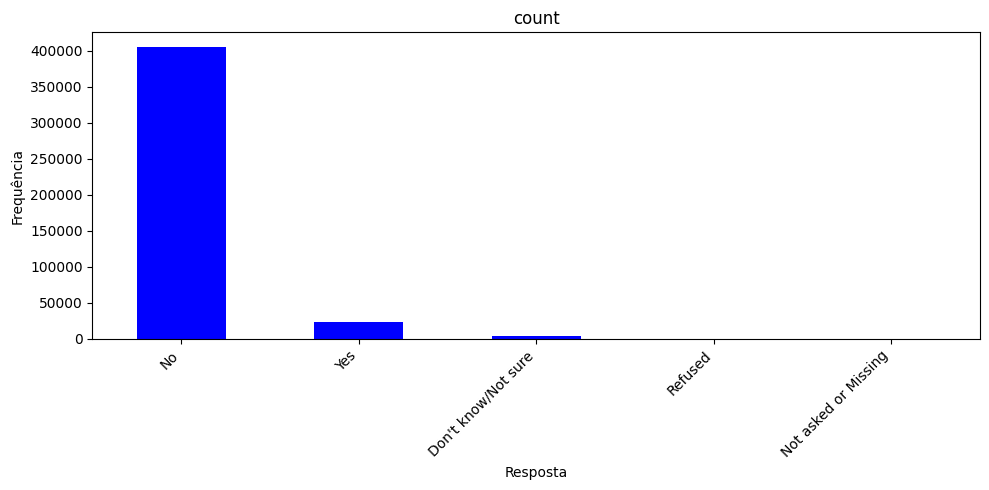

In [22]:
# df_brfss_2023_csv['CVDCRHD4'].value_counts().plot(kind = 'bar', title = 'Label Distribution')

# Gerar a série traduzida com rótulos
contagem_coronary = contar_com_rotulo(df_brfss_2023_csv, df_csv_path_expand_vars_translates, 'CVDCRHD4')

# Criar o gráfico de barras com rótulos legíveis
contagem_coronary.plot(kind='bar', title=contagem_coronary.name, figsize=(10, 5), color='blue')
plt.ylabel('Frequência')
plt.xlabel('Resposta')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

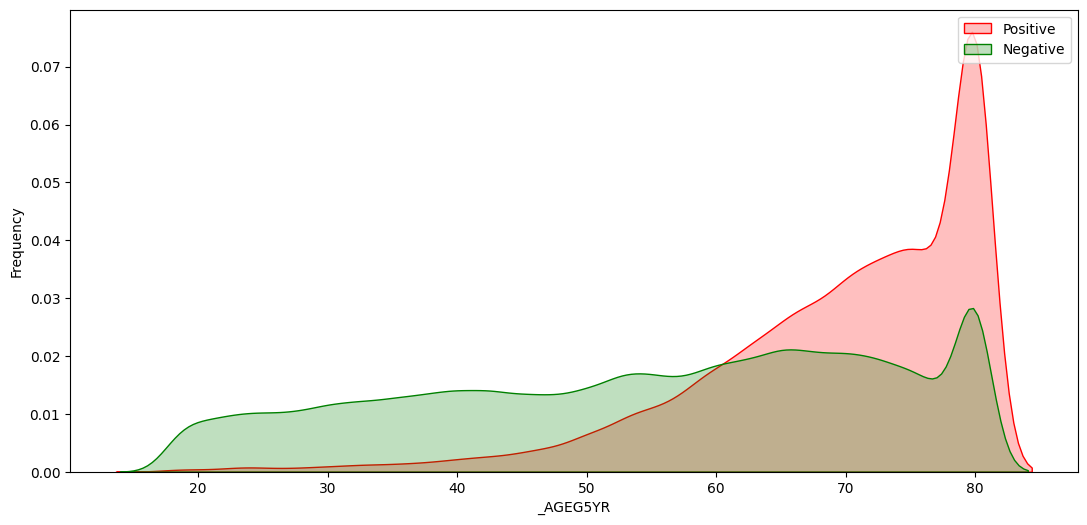

In [72]:
plt.figure(figsize=(13,6))
g = sns.kdeplot(df_brfss_2023_csv["_AGE80"][df_brfss_2023_csv["CVDCRHD4"] == 1.0], color="Red", fill = True)
g = sns.kdeplot(df_brfss_2023_csv["_AGE80"][df_brfss_2023_csv["CVDCRHD4"] == 2.0], ax =g, color="Green", fill= True)
g.set_xlabel("_AGEG5YR")
g.set_ylabel("Frequency")
g.legend(["Positive","Negative"])

### Sintomas Cardiológicos

In [46]:
sas_heart_simpt = 'Heart Attack and Stroke'
df_heart_attack_simp = df_csv_path_expand_vars_translates[df_csv_path_expand_vars_translates['Section Name'] == sas_heart_simpt]
df_heart_attack_simp = df_heart_attack_simp[['SAS Variable Name', 'Label', 'label_translate', 'section_name_translate', 'Value', 'Value Label', 'Frequency', 'Percentage', 'Weighted Percentage', 'value_label_translate']]
df_heart_attack_simp

,SAS Variable Name,Label,label_translate,section_name_translate,Value,Value Label,Frequency,Percentage,Weighted Percentage,value_label_translate
1155,HASYMP1,Heart Attack Symptoms - Jaw/Back/Neck Pain,Sintomas de ataque cardíaco - dores da mandíbu...,Ataque cardíaco e derrame,1,Yes,"6,471",61.50,56.36,Sim
1156,HASYMP1,Heart Attack Symptoms - Jaw/Back/Neck Pain,Sintomas de ataque cardíaco - dores da mandíbu...,Ataque cardíaco e derrame,2,No,"2,551",24.24,27.59,Não
1157,HASYMP1,Heart Attack Symptoms - Jaw/Back/Neck Pain,Sintomas de ataque cardíaco - dores da mandíbu...,Ataque cardíaco e derrame,7,Don't know/Not sure,"1,478",14.05,15.78,Não sei/não tenho certeza
1158,HASYMP1,Heart Attack Symptoms - Jaw/Back/Neck Pain,Sintomas de ataque cardíaco - dores da mandíbu...,Ataque cardíaco e derrame,9,Refused,22,0.21,0.26,Recusou
1159,HASYMP1,Heart Attack Symptoms - Jaw/Back/Neck Pain,Sintomas de ataque cardíaco - dores da mandíbu...,Ataque cardíaco e derrame,BLANK,Not asked or Missing,"422,801",.,.,Não perguntado ou desaparecido
...,...,...,...,...,...,...,...,...,...,...
1218,FIRSTAID,First Aid for Heart Attack and Stroke,Primeiros socorros para ataque cardíaco e derrame,Ataque cardíaco e derrame,4,Call their spouse or a family member,48,0.46,0.65,Ligue para o cônjuge ou um membro da família
1219,FIRSTAID,First Aid for Heart Attack and Stroke,Primeiros socorros para ataque cardíaco e derrame,Ataque cardíaco e derrame,5,Do something else,367,3.54,3.79,Fazer outra coisa
1220,FIRSTAID,First Aid for Heart Attack and Stroke,Primeiros socorros para ataque cardíaco e derrame,Ataque cardíaco e derrame,7,Don't know/Not sure,56,0.54,0.49,Não sei/não tenho certeza
1221,FIRSTAID,First Aid for Heart Attack and Stroke,Primeiros socorros para ataque cardíaco e derrame,Ataque cardíaco e derrame,9,Refused,21,0.20,0.25,Recusou


Lista das colunas dos sintomas

In [52]:
sintomas_list = list(df_heart_attack_simp['SAS Variable Name'].unique())

adicionadas as colunas de diagnóstico

In [54]:
# CVDINFR4 - Ever Diagnosed with Heart Attack
# CVDCRHD4 - Ever Diagnosed with Angina or Coronary Heart Disease
sintomas_list.append('CVDINFR4')
sintomas_list.append('CVDCRHD4')
sintomas_list

['HASYMP1',
 'HASYMP2',
 'HASYMP3',
 'HASYMP4',
 'HASYMP5',
 'HASYMP6',
 'STRSYMP1',
 'STRSYMP2',
 'STRSYMP3',
 'STRSYMP4',
 'STRSYMP5',
 'STRSYMP6',
 'FIRSTAID',
 'CVDINFR4',
 'CVDINFR4',
 'CVDCRHD4']

In [59]:
vars_cardio_list = [
 'HASYMP1',
 'HASYMP2',
 'HASYMP3',
 'HASYMP4',
 'HASYMP5',
 'HASYMP6',
#  'STRSYMP1',
#  'STRSYMP2',
#  'STRSYMP3',
#  'STRSYMP4',
#  'STRSYMP5',
#  'STRSYMP6',
#  'FIRSTAID',
 'CVDINFR4',
 'CVDCRHD4']

simp_list = [
 'HASYMP1',
 'HASYMP2',
 'HASYMP3',
 'HASYMP4',
 'HASYMP5',
 'HASYMP6',
]

df_brfss_2023_csv_copy = df_brfss_2023_csv.copy()
# filtrar pelo vars_cardio_list
df_brfss_2023_csv_copy = df_brfss_2023_csv_copy[vars_cardio_list]
# retirar linhas onde é missing data para a lista simp_list
df_brfss_2023_csv_copy = df_brfss_2023_csv_copy.dropna(subset=simp_list)
df_brfss_2023_csv_copy

,HASYMP1,HASYMP2,HASYMP3,HASYMP4,HASYMP5,HASYMP6,CVDINFR4,CVDCRHD4
206844,1.0,1.0,1.0,7.0,1.0,1.0,2.0,2.0
206845,7.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0
206847,1.0,1.0,1.0,7.0,1.0,1.0,2.0,2.0
206851,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0
206855,1.0,7.0,1.0,2.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
376946,7.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0
376947,1.0,1.0,1.0,7.0,1.0,1.0,2.0,2.0
376949,2.0,2.0,7.0,2.0,7.0,7.0,2.0,2.0
376950,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0


<Axes: >

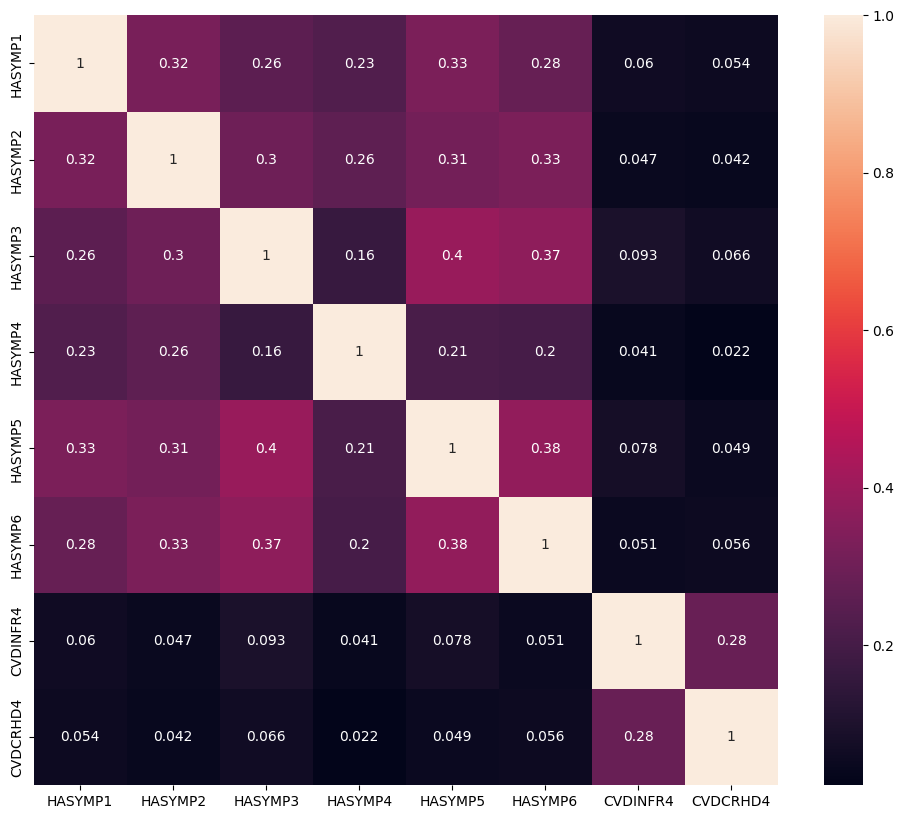

In [60]:
correlation = df_brfss_2023_csv_copy.corr()
plt.figure(figsize = (12,10))
sns.heatmap(correlation,annot = True)

### Filtrar BRFSS 2023 para colunas específicas

In [ ]:
# gerar um sub dataframe do dado para as colunas de interesse  ,onde essas variáveis não são missing data 
df_brfss_2023_csv_copy = df_brfss_2023_csv.copy()

heart_attack = 'CVDINFR4'
angina = 'CVDCRHD4'

# valores não nulos para as colunas de sintomas de ataque cardíaco e avc
df_brfss_2023_csv_copy = df_brfss_2023_csv_copy[df_brfss_2023_csv_copy[sas_vars_list].notnull().all(axis=1)]  
df_brfss_2023_csv_copy


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
206844,28.0,1.0,b'02212023',b'02',b'21',b'2023',1100.0,b'2023000090',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,1.0,1.0,2.0,9.0
206845,28.0,1.0,b'03042023',b'03',b'04',b'2023',1100.0,b'2023000091',2.023000e+09,1.0,...,1.400000e+01,2.0,6.000000e+02,1.0,NaN,NaN,2.0,1.0,1.0,2.0
206847,28.0,2.0,b'03192023',b'03',b'19',b'2023',1100.0,b'2023000093',2.023000e+09,1.0,...,1.000000e+02,1.0,7.000000e+02,1.0,NaN,NaN,1.0,2.0,2.0,2.0
206851,28.0,2.0,b'03262023',b'03',b'26',b'2023',1100.0,b'2023000097',2.023000e+09,1.0,...,5.700000e+01,2.0,1.600000e+03,2.0,NaN,NaN,2.0,1.0,1.0,2.0
206855,28.0,2.0,b'03122023',b'03',b'12',b'2023',1100.0,b'2023000101',2.023000e+09,1.0,...,1.400000e+01,2.0,9.990000e+04,9.0,NaN,NaN,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376946,51.0,12.0,b'12122023',b'12',b'12',b'2023',1100.0,b'2023006908',2.023007e+09,NaN,...,7.100000e+01,2.0,1.500000e+03,2.0,NaN,NaN,1.0,1.0,1.0,2.0
376947,51.0,12.0,b'12112023',b'12',b'11',b'2023',1100.0,b'2023006909',2.023007e+09,NaN,...,3.000000e+00,1.0,2.300000e+01,1.0,NaN,NaN,2.0,1.0,1.0,2.0
376949,51.0,12.0,b'12152023',b'12',b'15',b'2023',1200.0,b'2023006911',2.023007e+09,NaN,...,1.000000e+02,2.0,5.600000e+03,2.0,NaN,NaN,9.0,2.0,2.0,2.0
376950,51.0,12.0,b'12152023',b'12',b'15',b'2023',1100.0,b'2023006912',2.023007e+09,NaN,...,4.300000e+01,1.0,3.000000e+02,1.0,NaN,NaN,1.0,1.0,1.0,2.0


In [78]:
# Aplicar seleção de variáveis com menos de 25 % de missing após filtrar o Heart Attack and Stroke
df_brfss_2023_filtered_columns_csv = df_brfss_2023_csv_copy.copy()

# Calcular o percentual de valores nulos por coluna
percentual_na = df_brfss_2023_filtered_columns_csv.isnull().mean() * 100

# Selecionar colunas com menos de 25% de valores nulos - usar < 25
colunas_boas = percentual_na[percentual_na == 0].index

# Criar novo DataFrame apenas com essas colunas
df_brfss_2023_csv_filtered = df_brfss_2023_filtered_columns_csv[colunas_boas]

# Exibir informações do DataFrame filtrado
df_brfss_2023_csv_filtered.info()

# Exibir o DataFrame
df_brfss_2023_csv_filtered

<class 'pandas.core.frame.DataFrame'>
Index: 10359 entries, 206844 to 376951
Columns: 131 entries, _STATE to _DRNKDRV
dtypes: float64(126), object(5)
memory usage: 10.4+ MB


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,SEXVAR,...,_CURECI2,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
206844,28.0,1.0,b'02212023',b'02',b'21',b'2023',1100.0,b'2023000090',2.023000e+09,2.0,...,1.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,9.0
206845,28.0,1.0,b'03042023',b'03',b'04',b'2023',1100.0,b'2023000091',2.023000e+09,1.0,...,1.0,1.0,1.400000e+01,2.0,6.000000e+02,1.0,2.0,1.0,1.0,2.0
206847,28.0,2.0,b'03192023',b'03',b'19',b'2023',1100.0,b'2023000093',2.023000e+09,2.0,...,1.0,1.0,1.000000e+02,1.0,7.000000e+02,1.0,1.0,2.0,2.0,2.0
206851,28.0,2.0,b'03262023',b'03',b'26',b'2023',1100.0,b'2023000097',2.023000e+09,2.0,...,1.0,1.0,5.700000e+01,2.0,1.600000e+03,2.0,2.0,1.0,1.0,2.0
206855,28.0,2.0,b'03122023',b'03',b'12',b'2023',1100.0,b'2023000101',2.023000e+09,2.0,...,1.0,1.0,1.400000e+01,2.0,9.990000e+04,9.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376946,51.0,12.0,b'12122023',b'12',b'12',b'2023',1100.0,b'2023006908',2.023007e+09,1.0,...,1.0,1.0,7.100000e+01,2.0,1.500000e+03,2.0,1.0,1.0,1.0,2.0
376947,51.0,12.0,b'12112023',b'12',b'11',b'2023',1100.0,b'2023006909',2.023007e+09,2.0,...,1.0,1.0,3.000000e+00,1.0,2.300000e+01,1.0,2.0,1.0,1.0,2.0
376949,51.0,12.0,b'12152023',b'12',b'15',b'2023',1200.0,b'2023006911',2.023007e+09,1.0,...,1.0,1.0,1.000000e+02,2.0,5.600000e+03,2.0,9.0,2.0,2.0,2.0
376950,51.0,12.0,b'12152023',b'12',b'15',b'2023',1100.0,b'2023006912',2.023007e+09,1.0,...,1.0,1.0,4.300000e+01,1.0,3.000000e+02,1.0,1.0,1.0,1.0,2.0


In [73]:
percentual_na

_STATE       0.000000
FMONTH       0.000000
IDATE        0.000000
IMONTH       0.000000
IDAY         0.000000
              ...    
_PNEUMO3    59.735496
_AIDTST4     0.000000
_RFSEAT2     0.000000
_RFSEAT3     0.000000
_DRNKDRV     0.000000
Length: 350, dtype: float64

In [72]:
# com as colunas do dataframe filtrado , podemos trazer parte do codebook com os dados desas colunas
# E inclusivev verificar o Label se faz sentido para a análise voltada para estudo cardiológico

df_brfss_2023_csv_filtered_list_col = list(df_brfss_2023_csv_filtered.columns)

df_brfss_2023_variaveis = pd.read_csv(f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis.csv")

df_vars_2023_filtered_nan_vars = df_brfss_2023_variaveis[df_brfss_2023_variaveis['SAS Variable Name'].isin(df_brfss_2023_csv_filtered_list_col)]
df_vars_2023_filtered_nan_vars

,Label,Section Name,Section Number,Question Number,Column,Type of Variable,SAS Variable Name,Question Prologue,Question,Core Section Number,Module Number
0,State FIPS Code,Record Identification,0.0,1,1-2,Num,_STATE,NaN,State FIPS Code,NaN,NaN
1,File Month,Record Identification,0.0,8,17-18,Num,FMONTH,NaN,File Month,NaN,NaN
2,Interview Date,Record Identification,0.0,9,19-26,Char,IDATE,NaN,Interview Date,NaN,NaN
3,Interview Month,Record Identification,0.0,10,19-20,Char,IMONTH,NaN,Interview Month,NaN,NaN
4,Interview Day,Record Identification,0.0,11,21-22,Char,IDAY,NaN,Interview Day,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
337,Heavy Alcohol Consumption Calculated Variable,Calculated Variables,NaN,5,2104,Num,_RFDRHV8,NaN,Heavy drinkers (adult men having more than 14 ...,NaN,12.0
340,Ever been tested for HIV calculated variable,Calculated Variables,NaN,1,2107,Num,_AIDTST4,NaN,Adults who have ever been tested for HIV,NaN,14.0
341,Always or Nearly Always Wear Seat Belts,Calculated Variables,NaN,1,2108,Num,_RFSEAT2,NaN,Always or Nearly Always Wear Seat Belts Calcul...,NaN,15.0
342,Always Wear Seat Belts,Calculated Variables,NaN,2,2109,Num,_RFSEAT3,NaN,Always Wear Seat Belts Calculated Variable,NaN,15.0


In [ ]:
# definir as categorias importantes 
# retornar as variáveis das categorias 
# gerar um sub dataframe de análise usando o dataframe de vari-aveis por grupo relevante
# distribuição das variáveis por categoria
# usar o codebook para transformar os números inteiros em informações

Filtrando uma fração do dataframe conforme as variáveis desejadas

In [ ]:
# agora com os dados devidamente mapeados é possível fazer a análise exploratória dos dados
df_2023_to_explore = df_2023_csv.copy()


# filtrar a coluna '_AGEG5YR' onde os valoes são 3 4 5 e 6
df_2023_to_explore = df_2023_to_explore[df_2023_to_explore['_AGEG5YR'].isin([3, 4, 5, 6])] # idade
# trazer as idades do codebook converter no datafraeme e fazer a distribuição

df_2023_to_explore = df_2023_to_explore[df_2023_to_explore['CVDINFR4'].isin([1, 2])] # ataque cardíaco

df_2023_to_explore

# filtrar do csv as idades desejadas 




,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
46,1.0,2.0,b'04102023',b'04',b'10',b'2023',1100.0,b'2023000047',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0,1.0,1.0,9.0
54,1.0,3.0,b'05042023',b'05',b'04',b'2023',1100.0,b'2023000055',2.023000e+09,1.0,...,1.000000e+01,1.0,2.100000e+02,1.0,NaN,NaN,1.0,2.0,2.0,2.0
61,1.0,3.0,b'04272023',b'04',b'27',b'2023',1100.0,b'2023000062',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,1.0,1.0,1.0,9.0
69,1.0,1.0,b'03012023',b'03',b'01',b'2023',1100.0,b'2023000070',2.023000e+09,1.0,...,8.600000e+01,2.0,2.400000e+03,2.0,NaN,NaN,2.0,1.0,1.0,2.0
90,1.0,2.0,b'04252023',b'04',b'25',b'2023',1200.0,b'2023000091',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,1.0,1.0,1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433314,78.0,12.0,b'12082023',b'12',b'08',b'2023',1100.0,b'2023002060',2.023002e+09,NaN,...,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,1.0,1.0,1.0,9.0
433315,78.0,12.0,b'12122023',b'12',b'12',b'2023',1200.0,b'2023002061',2.023002e+09,NaN,...,9.000000e+02,9.0,9.990000e+04,9.0,NaN,NaN,NaN,9.0,9.0,9.0
433317,78.0,12.0,b'01052024',b'01',b'05',b'2024',1100.0,b'2023002063',2.023002e+09,NaN,...,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,1.0,1.0,2.0,9.0
433319,78.0,12.0,b'01032024',b'01',b'03',b'2024',1100.0,b'2023002065',2.023002e+09,NaN,...,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,1.0,1.0,1.0,9.0


In [ ]:
# definir as colunas que serão utilizadas para a análise
# filtrar utilizando o dataframe de suporte com os dados das variáveis

# questões cardiológicas 
# gerar um dicionário do dado codebook para consumir no código

Existem 7 colunas do dado, que não estão descritas no odebook. Verificar se estão descritas em codebooks de anos anteriores

In [18]:
list_df_vars_2023 = df_vars_2023['SAS Variable Name']
len(list_df_vars_2023)

344

In [ ]:
# data sas 
'''set_brfss_2023_columns = set(brfss_2023_columns)
set_list_df_vars_2023 = set(list_df_vars_2023)
diff = set_brfss_2023_columns - set_list_df_vars_2023
diff'''

{'BIRTHSEX',
 'CELSXBRT',
 'LNDSXBRT',
 'RCSGEND1',
 'RCSXBRTH',
 'TRNSGNDR',
 'USEMRJN4'}

# Filtragem de dados para variáveis alvo

In [ ]:
# da categoria 'Chronic Health Conditions'
# temos duas variáveis que podemos usar como alvo
# CVDINFR4 Heart Attack
# CVDCRHD4 Angina
# temos um grupo de variáveis com sintomas de doenças cardíacas 'Heart Attack and Stroke',


# definir a variável alvo , onde temos os valores 1 - sim e 2 não
# trazer as colunas sem missing data após essa filtragem da var alvo

# dados entre 30 e 50 anos
# quantos tiveram e quantos nãotiveram problema cardíaco



## CVDINFR4 Heart Attack

In [ ]:
var_code_heart_attack = "CVDINFR4"
json_path_file_to_csv = f"{notebook_dir_project_predict}data{os.sep}intermediate{os.sep}2023{os.sep}brfss_2023_variaveis.json"

var_info_explore = consultar_var_data_features(json_file_path=json_path_file_to_csv, 
                                       sas_variable_name=var_code_heart_attack,
                                       sas_variable_feature='var_info')

if var_info_explore:
    # Criar DataFrame com os dados de var_info
    df_var_info_test = pd.DataFrame(var_info)
    
else:
    print(f"Variável {sas_variable_heart} não encontrada.")

df_var_info_test

## CVDCRHD4 Angina

In [ ]:
# Variáveis relevanrtes
# mapa de correlação
# idade  e dados faltantes

# análise explratória  e distribuições por idade 

# Estatística descritiva das variáveis

In [ ]:
# subset data to only include the columns we want
''' 
PRÉ-PROCESSAMENTO

Perguntas a responder

Triagem de colunas (tirar as com excesso de missing data)

Checagem e limpeza dos dados (ver se os numéricos são só numéricos mesmo; limpeza de outliers usando MAD)

Imputação de dados faltantes (kNN)

Checar se labels são balanced ou unbalanced

SUB-AMOSTRAGEM

Definir variáveis que se busca manter em proporções similares entre train e test sets

Definir modelos ML a serem testados

Definir quantidade de "folds" e de indivíduos independentes por fold de análise, em quase todos eles usando cross-validation (Bayesian feature ranking + feature selection a partir do ranking; modelos ML; grid-search melhor modelo; fold de VALIDATION, pra testar os 3 melhores grid-searches pro modelo, usando todos os folds anteriores como TRAIN; fold TEST para averiguação final da regressão e/ou classificação, usando todos os anteriores como TRAIN).

Obtenção dos folds (caret - R) respeitando proporção das variáveis nos dados brutos

'''

# BRFSS 2022

https://www.cdc.gov/brfss/annual_data/annual_2022.html

The 2022 BRFSS data continue to reflect the changes initially made in 2011 for weighting methodology (raking) and adding cell-phone-only respondents. The aggregate BRFSS combined landline and cell phone data set is built from the landline and cell phone data submitted for 2022 and includes data from 50 states, the District of Columbia, Guam, Puerto Rico, and the US Virgin Islands.

In [15]:
# Caminho para o arquivo XPT (extraído do ZIP)
arquivo_xpt_2022 = "/home/ed/lgcm/projects/riskPredictionDeseases/data/input/LLCP2022XPT/LLCP2022.XPT "

# Carregar o arquivo no pandas
df_2022 = pd.read_sas(arquivo_xpt_2022, format='xport')
df_2022

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_SMOKGRP,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000001',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,2.0,2.0
1,1.0,1.0,b'02042022',b'02',b'04',b'2022',1100.0,b'2022000002',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0
2,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000003',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0
3,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000004',2.022000e+09,1.0,...,3.0,2.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0,9.0,9.0,2.0
4,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000005',2.022000e+09,1.0,...,4.0,NaN,1.0,1.000000e+01,1.0,1.400000e+02,1.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,78.0,11.0,b'12192022',b'12',b'19',b'2022',1100.0,b'2022001527',2.022002e+09,NaN,...,4.0,NaN,7.0,9.000000e+02,9.0,9.990000e+04,9.0,NaN,NaN,1.0
445128,78.0,11.0,b'12212022',b'12',b'21',b'2022',1100.0,b'2022001528',2.022002e+09,NaN,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,1.0
445129,78.0,11.0,b'11292022',b'11',b'29',b'2022',1100.0,b'2022001529',2.022002e+09,NaN,...,1.0,NaN,7.0,9.000000e+02,9.0,9.990000e+04,9.0,2.0,2.0,2.0
445130,78.0,11.0,b'12082022',b'12',b'08',b'2022',1100.0,b'2022001530',2.022002e+09,NaN,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,1.0
